In [1]:
using BenchmarkTools
paramsfile = [ "benchmark-2020-05-29_18h49.json", 
    "benchmark-2020-06-01_15h36.json",
    "benchmark-2020-06-03_14h36.json", 
    "benchmark-2020-06-03_22h53.json",
    "benchmark-2020-06-07_12h06.json"][end]
results = BenchmarkTools.load(paramsfile)[1]

using StructArrays
using DataFrames

data = StructArray([ (pattern=t[1][1], string = t[1][4], code=t[1][2], trial = t[2].time)
              for t in leaves(median(results))
              if t[1][3]=="match" ]) |> DataFrame 
data = unstack(data, [ :pattern, :string], :code, :trial)

data[!,:creation] .= data.string.=="1"
data[!,:ratio] .= data.Regcomb./data.Regex

groupby(data,:pattern)
adata = filter(row -> row.ratio!==missing && row.ratio>0.0 && row.ratio!=NaN && !(row.pattern in ["69","70"]),
                    sort(data, :Regcomb, rev=true))

adata[!,:type] = [ c ? "constructor" : "match" for c in adata.creation ]
adata[!,:lratio] = log10.(adata.ratio)
sort(data, :ratio, rev=true)

,pattern,string,Regcomb,Regex,creation,ratio
,String,String,Float64?,Float64?,Bool,Float64
1,70,4,62122.5,327.0,0,189.977
2,70,1,33501.5,323.0,1,103.72
3,70,3,17575.0,228.0,0,77.0833
4,6,8,28515.5,401.0,0,71.111
5,70,5,30378.0,433.0,0,70.157
6,70,6,20405.0,314.0,0,64.9841
7,69,4,21753.0,443.0,0,49.1038
8,69,1,10043.0,337.0,1,29.8012
9,69,6,7399.5,343.0,0,21.5729


In [2]:
#groupby(data,:pattern)[9]
( range_Regcomb = extrema(filter(x->x!==missing,adata.Regcomb)),
  range_Regex = extrema(filter(x->x!==missing,adata.Regex)),
  proportion_better = sum([ ratio < 1.0 ? 1 : 0 for ratio in adata.ratio])/size(adata)[1],
  mean_ratio = mean(filter(x->x!==missing,adata.ratio)),
  ratio_mean = 10^(mean(log10.(filter(x->x!==missing,adata.Regcomb)))-
                   mean(log10.(filter(x->x!==missing,adata.Regex)))))

(range_Regcomb = (33.0, 28515.5), range_Regex = (83.0, 682.5), proportion_better = 0.5093632958801498, mean_ratio = 2.7263015758568434, ratio_mean = 1.2951982070322912)

┌ Info: For saving to png with the Plotly backend ORCA has to be installed.
└ @ Plots /home/gregor/.julia/packages/Plots/cc8wh/src/backends.jl:363


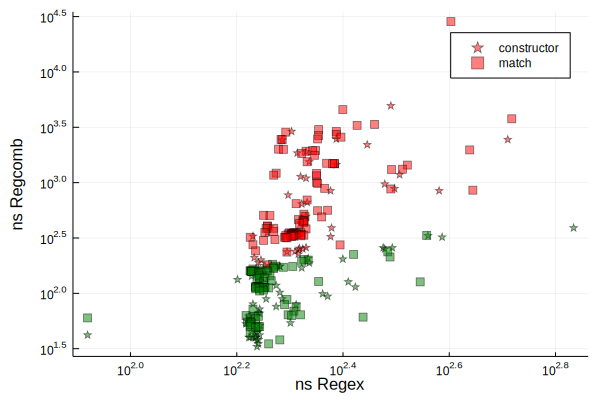

In [4]:
using StatsPlots
plotly()
Plots.PlotlyBackend()
gr()
scatter(adata.Regex, adata.Regcomb, 
    group = adata.type,
    markercolor= [ ratio < 1 ? :green : :red 
        for ratio in adata[!,(:ratio)] ],
    markershape= [ creation ? :star : :rect 
        for creation in adata[!,(:creation)] ],
    alpha=.5)

xaxis!("ns Regex", :log10)#, xlim=(150,600))
yaxis!("ns Regcomb", :log10)

In [5]:
savefig("log_btimes.png")

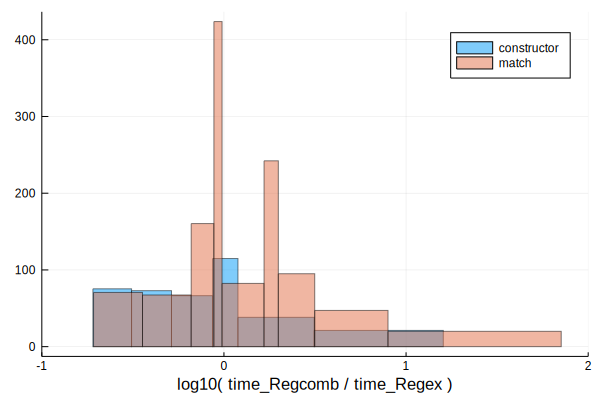

In [10]:
@df adata ea_histogram(:lratio;group=:type,bins=:scott,xlim=(-1,2),bar_position=:stack, alpha=.5, xlabel="log10( time_Regcomb / time_Regex )")

In [8]:
savefig("log_btime_ratio_histogram.svg")

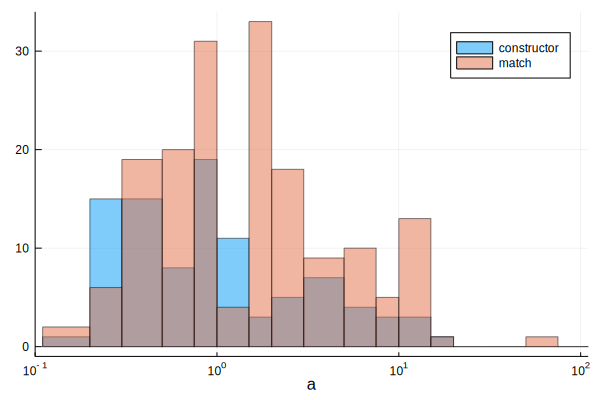

In [9]:
scale = (:xscale=>:log10, 
         :xlim=>(.1,110), 
        :bins=>[.11,.2,.3,.5,.75,1,1.5,2,3,5,7.5,10,15,20,30,50,75,100,1000])
@df adata histogram(:ratio; scale...,group=:type, bar_position=:stack, alpha=.5, xlabel="a")

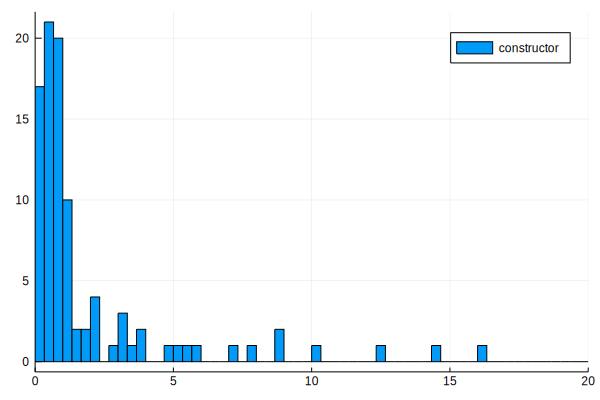

In [16]:
@df filter(x->x.creation,adata) histogram(:ratio; label="constructor", xlim=(0,20),bins=Float64[0:60...]./3.0)

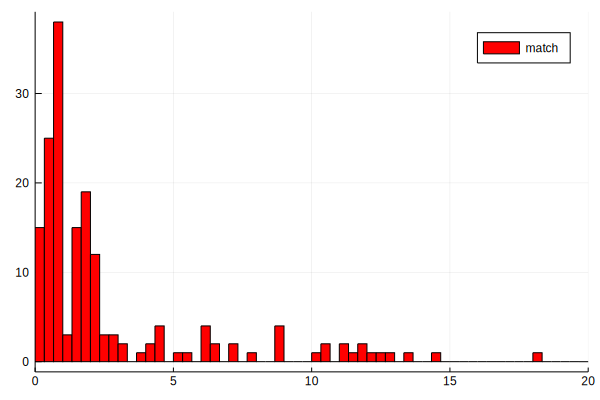

In [56]:
@df filter(x->!x.creation,adata) histogram(:ratio; label="match", color=:red, xlim=(0,20),bins=Float64[0:60...]./3.0)
